In [1]:
# 生成对抗网络。
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

train = pd.read_csv('datasets/fashionmnist/fashion-mnist_train.csv')

X_train = train.drop('label', axis=1)

mm_scaler = MinMaxScaler(feature_range=(0,1))
X_train = mm_scaler.fit_transform(X_train)
real_samples, dim = X_train.shape

/Users/michael/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [2]:
import tensorflow as tf
BATCH_SIZE = 256
N_BATCHES = real_samples / BATCH_SIZE
N_EPOCHS = 500
LEARNING_RATE = 1e-4
REAL_INPUT_UNITS = 784
HIDDEN_UNITS = 256
NOISE_INPUT_UNITS = 40

/Users/michael/anaconda/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def generator(noise_img, hidden_units, output_dim, reuse=False):
    with tf.variable_scope('generator', reuse=reuse):
        hidden_layer = tf.layers.dense(noise_img, hidden_units, activation=tf.nn.relu)
        gen_img = tf.layers.dense(hidden_layer, output_dim, activation=tf.nn.sigmoid)
    return gen_img

In [4]:
def discriminator(img, hidden_units, output_dim, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        hidden_layer = tf.layers.dense(img, hidden_units, activation=tf.nn.relu)
        dis_logits = tf.layers.dense(hidden_layer, output_dim, activation=None)
        return dis_logits

In [5]:
real_imgs = tf.placeholder(tf.float32, shape=(None, REAL_INPUT_UNITS), name='real_imgs')
noise_imgs = tf.placeholder(tf.float32, shape=(None, NOISE_INPUT_UNITS), name='noise_imgs')

gen_imgs = generator(noise_imgs, HIDDEN_UNITS, REAL_INPUT_UNITS)

dis_real_logits = discriminator(real_imgs, HIDDEN_UNITS, 1)
dis_fake_logits = discriminator(gen_imgs, HIDDEN_UNITS, 1, reuse=True)

dis_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_real_logits, labels=tf.ones_like(dis_real_logits)))
dis_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_fake_logits, labels=tf.zeros_like(dis_fake_logits)))                           

dis_loss = dis_real_loss + dis_fake_loss

gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_fake_logits, labels=tf.ones_like(dis_fake_logits)))

train_vars = tf.trainable_variables()

dis_vars = [var for var in train_vars if var.name.startswith('discriminator')]
dis_train_opt = tf.train.AdamOptimizer(LEARNING_RATE).minimize(dis_loss, var_list=dis_vars)

gen_vars = [var for var in train_vars if var.name.startswith('generator')]
gen_train_opt = tf.train.AdamOptimizer(LEARNING_RATE).minimize(gen_loss, var_list=gen_vars)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

samples = []

with tf.Session() as sess:
    init.run()
    
    max_dis_loss = -np.inf
    min_gen_loss = np.inf
    
    
    for iteration in range(N_EPOCHS):
        for i in range(N_BATCHES):
            np.random.seed(iteration * N_BATCHES + i)
            
            indices = np.random.randint(real_samples, size=BATCH_SIZE)
            
            batch_real_imgs = X_train[indices]
            batch_noise_imgs = np.random.uniform(-1, 1, size=(BATCH_SIZE, NOISE_INPUT_UNITS))
            
            sess.run(dis_train_opt, feed_dict={real_imgs: batch_real_imgs, noise_imgs: batch_noise_imgs})
            sess.run(gen_train_opt, feed_dict={noise_imgs: batch_noise_imgs})
            
        d_loss, g_loss = sess.run([dis_loss, gen_loss], feed_dict={real_imgs:batch_real_imgs, noise_imgs: batch_noise_imgs})
        

        sample_noise = np.random.uniform(-1, 1, size=(20, NOISE_INPUT_UNITS))

        gen_samples = sess.run(generator(noise_imgs, HIDDEN_UNITS, REAL_INPUT_UNITS, reuse=True),
                           feed_dict={noise_imgs: sample_noise})
        samples.append(gen_samples)
    
        # 存储checkpoints       
        if max_dis_loss < d_loss and min_gen_loss > g_loss:
            max_dis_loss = d_loss
            min_gen_loss = g_loss
            saver.save(sess, 'models/section_3.8/my_final_model.ckpt')
        
            print 'Iteration %d: d_loss = %f, g_loss = %f' % (iteration + 1, max_dis_loss, min_gen_loss)

Iteration 1: d_loss = 0.145449, g_loss = 3.522944
Iteration 2: d_loss = 0.188410, g_loss = 2.781441
Iteration 4: d_loss = 0.287448, g_loss = 2.469594
Iteration 7: d_loss = 0.351462, g_loss = 1.918314
Iteration 12: d_loss = 0.430663, g_loss = 1.803702
Iteration 49: d_loss = 0.530301, g_loss = 1.602564
Iteration 88: d_loss = 0.707302, g_loss = 1.404850
Iteration 143: d_loss = 0.787684, g_loss = 1.403219
Iteration 232: d_loss = 0.916425, g_loss = 1.375341


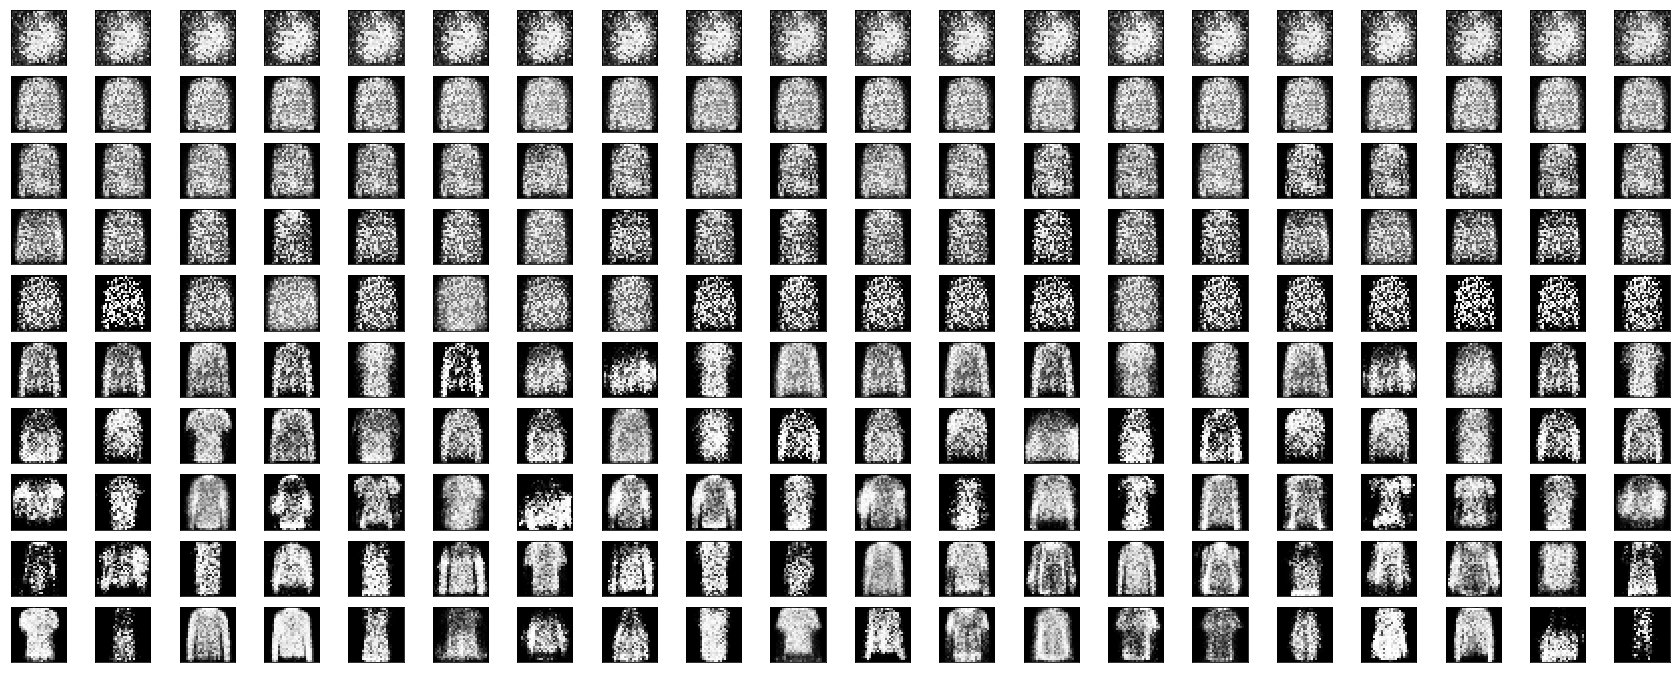

In [6]:
from matplotlib import pyplot as plt

idx = [0, 2, 5, 10, 20, 50, 100, 250, 400, 490]
rows, cols = len(idx), 20
fig, axes = plt.subplots(figsize=(30,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

show_imgs = []
for i in idx:
    show_imgs.append(samples[i])
    
for sample, ax_row in zip(show_imgs, axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
plt.show()
